In [1]:
%pylab notebook
from time import sleep
import sys
rcParams["axes.grid"] = True

sys.path.append("..")
from common import *

sys.path.append("../linux/csr_access/py/")
from csr_lib import CsrLib, CsrLibLegacyAdapter
from vvm_helpers import initLTC, getSamples, getNyquist, meas_f_ref, twos_comps, getMags, getPhases, CalHelper

from socket_instrument import SocketInstrument
from skrf import Network, Frequency

def set_center_freq(f_ref):
    f_tune, isInverted = getNyquist(f_ref, f_sample)
    ftw = int(f_tune / f_sample * 2**32)
    # Setup center frequency / measurement harmonic
    for i, mult in enumerate(Ms):
        ftw_ = int(ftw * mult)
        getattr(r.regs, 'vvm_ddc_dds_ftw{}'.format(i)).write(ftw_)
#         if i > 0:
#             getattr(r.regs, 'vvm_pp_mult{}'.format(i)).write(mult)
    r.regs.vvm_ddc_dds_ctrl.write(0b10)  # FTW_UPDATE
    return isInverted

def doSweep(f_test):
    mags = []
    phases = []
    for f in f_test:
        s.write("SOURCE:FREQUENCY {:}".format(f))
        isInverted = set_center_freq(f)
        sleep(.1)
        mags.append(getMags(r, vvm_ddc_shift))
        p = getPhases(r)
        if isInverted:
            p *= -1
        phases.append(p)
    mags = vstack(mags)
    phases = vstack(phases)
    return mags, phases

def getBadInds(f_test, f_sample, f_thr=1e6):
    ''' Indicate frequencies too close to 0 Hz or N * fSample / 2 '''
    bad_inds = zeros_like(f_test, dtype=bool)
    for i in range(16):
        bad_f = f_sample / 2 * i
        bad_inds |= abs(f_test - bad_f) < f_thr
    return bad_inds

Populating the interactive namespace from numpy and matplotlib


# Connect and init VVM

In [2]:
r = conLitexServer('../../build/csr.csv')
c = CsrLibLegacyAdapter(r)
print("f_sample:", r.regs.lvds_f_sample_value.read() / 1e6, "MHz")
initLTC(c)

Connected to Port 1234
Zedboard RF vector volt-meter 2020-01-09 18:20:40
f_sample: 117.600725 MHz
Resetting LTC
autoBitslip(): aligned after 4
ID: 16  F: 11110000
CH0: 0000000000000001
CH1: 0000000000000001
CH2: 0000000000000001
CH3: 0000000000000001
autoIdelay(): min = 9, mean = 15, max = 21 idelays


# Setup VVM parameters

In [3]:
# Frequency / bandwidth setting
vvm_ddc_deci = 100  # vvm_ddc_decimation factor
vvm_ddc_shift = 2
f_sample = 117.6e6  # Sampling clock frequency
Ms = (1, 1, 1, 1) # Measurement harmonic
iir_shift = 6

# Setup vvm_ddc_decimation factor
r.regs.vvm_ddc_deci.write(vvm_ddc_deci)

# Throw away N bits after CIC to avoid saturation with large vvm_ddc_deci factors
# This will change the scaling!
r.regs.vvm_ddc_shift.write(vvm_ddc_shift)

# IIR result averaging filter smoothing factor (0 - 15)
r.regs.vvm_iir.write(iir_shift)

set_center_freq(499.6e6)
r.regs.vvm_ddc_dds_ctrl.write(0b01)  # Reset phases

print('f_sample', r.regs.lvds_f_sample_value.read() / 1e6, "MHz")
print('f_ref', meas_f_ref(c, f_sample) / 1e6, "MHz")
print('vvm_ddc_deci', r.regs.vvm_ddc_deci.read())
print('bw', f_sample / vvm_ddc_deci / 1e6, "MHz")
print('iir_shift', r.regs.vvm_iir.read())

f_sample 117.600725 MHz
f_ref 29.599223807999998 MHz
vvm_ddc_deci 100
bw 1.176 MHz
iir_shift 6


# Connect to RS SMA100A

In [4]:
s = SocketInstrument("192.168.19.234", 5025)
s.__enter__()

In [5]:
s.ask("*IDN?")

'Rohde&Schwarz,SMA100A,1400.0000k02/111390,3.1.19.15-3.50.057.29'

# Do a frequency sweep
Connect Power divider output to REF + CHX

### Setup frequency vector

In [6]:
f_test = linspace(10e6, 800e6, 500)
# f_test = linspace(400e6, 600e6, 50)
p_test = 16.0 # [dBm]

bad_inds = getBadInds(f_test, f_sample)
# f_test = f_test[~bad_inds]
mag_results = zeros((len(f_test), 4))
phase_results = zeros((len(f_test), 3))

### First Sweep: splitter on REF + CHA

In [7]:
mags, phases = doSweep(f_test)

mag_results[:, :2] = mags[:, :2]
phase_results[:, 0] = phases[:, 0]

### Second Sweep: splitter on REF + CHB

In [9]:
mags, phases = doSweep(f_test)

mag_results[:, 2] = mags[:, 2]
phase_results[:, 1] = phases[:, 1]

### Third Sweep: splitter on REF + CHC

In [11]:
mags, phases = doSweep(f_test)

mag_results[:, 3] = mags[:, 3]
phase_results[:, 2] = phases[:, 2]

# Plot results

<IPython.core.display.Javascript object>


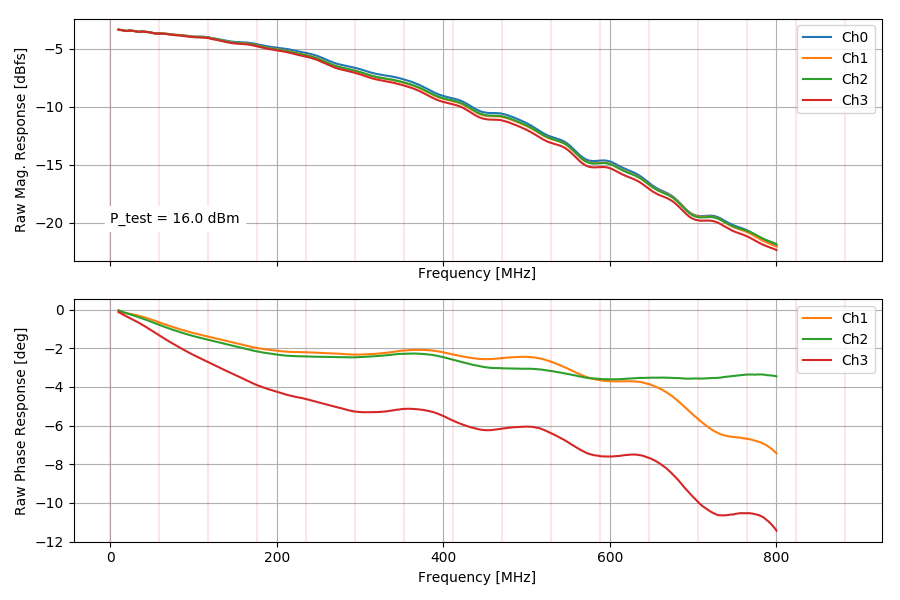

In [12]:
close()
fig, axs = subplots(2, 1, sharex=True, figsize=(9, 6))

ax = axs[0]
for i, m in enumerate(mag_results.T):
    ax.plot(f_test[~bad_inds] / 1e6, m[~bad_inds], label="Ch{:}".format(i))
ax.text(0, -20, "P_test = {:.1f} dBm".format(p_test), bbox={"color": "white"})
ax.set_ylabel("Raw Mag. Response [dBfs]")

ax = axs[1]
ax.set_prop_cycle(rcParams['axes.prop_cycle'][1:])
for i, p in enumerate(phase_results.T):
    ax.plot(f_test[~bad_inds] / 1e6, p[~bad_inds], label="Ch{:}".format(i + 1))
ax.set_ylabel("Raw Phase Response [deg]")

for ax in axs:
    ax.set_xlabel("Frequency [MHz]")
    ax.legend()
    for i in range(16):
        ax.axvline(f_sample / 2 * i / 1e6, color="red", alpha=0.1)

fig.tight_layout()
# fig.savefig("raw_response.png")

# Remove measurement cable loss and phase
this includes
  * Mini circuits power splitter `Z99SC-62-S+`
  * Mini circuits SMA cable on its in and outputs: `CBL-0.5M-SMSM+`

In [13]:
n1 = Network('vna/PDIV_CH1.S2P')
n1.resample(Frequency.from_f(f_test, unit="Hz"))
n2 = Network('vna/PDIV_CH2.S2P')
n2.resample(Frequency.from_f(f_test, unit="Hz"))

<IPython.core.display.Javascript object>


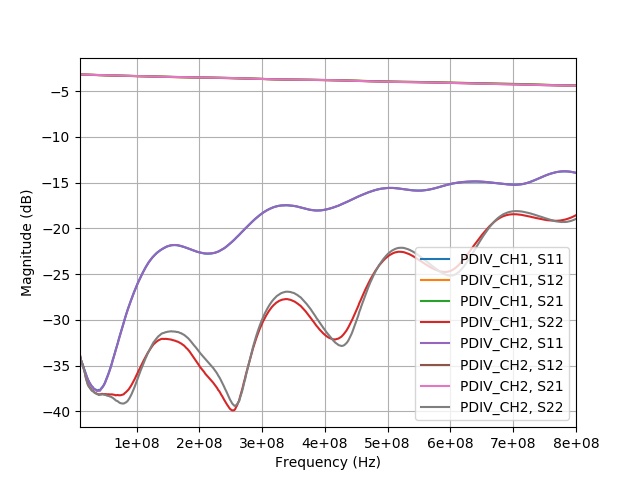

In [14]:
close()
n1.plot_s_db()
n2.plot_s_db()

<IPython.core.display.Javascript object>


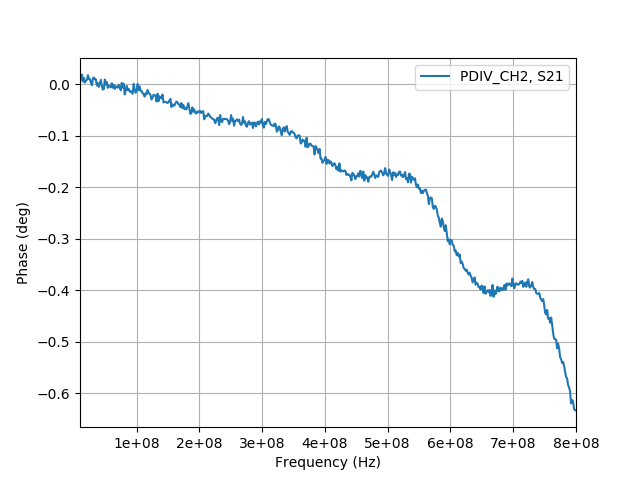

In [15]:
close()
# Subtract the phase of the REF channel
(n2 / n1).plot_s_deg_unwrap(1, 0)

# Some intermediate results

In [16]:
# Calibrated power over frequency at frontpanel SMA connector
loss1_db = n1.s_db[:, 1, 0]
loss2_db = n2.s_db[:, 1, 0]
power_in_dbm = p_test + array((loss1_db, loss2_db, loss2_db, loss2_db)).T

# Calibration factor to add to raw magnitude (in dB)
power_cal_db = power_in_dbm - mag_results
power_cal_db

array([[16.17274854, 16.17646728, 16.17822132, 16.18659445],
       [16.199406  , 16.20361325, 16.20636334, 16.21502264],
       [16.20038979, 16.20439289, 16.20817222, 16.21749916],
       ...,
       [33.51258631, 33.54725445, 33.34066849, 33.84799355],
       [33.56887304, 33.59532586, 33.38413441, 33.89324189],
       [33.62928335, 33.64990376, 33.43779815, 33.94691814]])

In [17]:
# Calibrated phase difference over frequency at frontpanel SMA connector
phase_in_deg = (n2 / n1).s_deg[:, 1, 0]
phase_in_deg = atleast_2d(phase_in_deg).T

# Calibration factor to add to raw phase (in deg)
phase_cal_deg = phase_in_deg - phase_results
phase_cal_deg

array([[ 0.14612324,  0.03291256,  0.11865742],
       [ 0.15513209,  0.06955889,  0.16929415],
       [ 0.17005935,  0.10620132,  0.22035614],
       ...,
       [ 6.67616041,  2.78948934, 10.62265547],
       [ 6.73737451,  2.80341074, 10.7066147 ],
       [ 6.80241345,  2.81918286, 10.80641507]])

# Save cal file

In [19]:
savez_compressed(
    "cal2_att.npz",
    f_test=f_test, 
    mag_results=mag_results,
    phase_results=phase_results,
    bad_inds=bad_inds,
    vvm_ddc_deci=vvm_ddc_deci,
    vvm_ddc_shift=vvm_ddc_shift,
    f_sample=f_sample,
    Ms=Ms,
    iir_shift=iir_shift,
    p_test=p_test,
    power_cal_db=power_cal_db,
    phase_cal_deg=phase_cal_deg
)

# Load cal file

In [20]:
cal = CalHelper('cal2_att.npz')

In [22]:
f = 499.6e6
s.write("SOURCE:FREQUENCY {:}".format(f))
set_center_freq(f)
print(cal.get_mags(r, vvm_ddc_shift, f))
print(cal.get_phases(r, f))

[ 12.03584265 -46.58895209 -50.69495063  12.01364828]
[100.95517324  85.95986532  -0.18007112]


### do a quick sweep and confirm cal

In [23]:
def plot_cal(CH, fs, axs=None):
    fs = fs[~getBadInds(fs, f_sample)]

    mags, phases = doSweep(fs)
    
    mags_cor = zeros_like(mags)
    phases_cor = zeros_like(phases)
    
    for i, f in enumerate(fs):
        mags_cor[i], phases_cor[i] = cal.get_cals(f)
        
    mags_cor += mags
    phases_cor += phases
    
    fig = gcf()
    if axs is None:
        close()
        if CH > 0:
            fig, axs = subplots(2, 1, sharex=True, figsize=(9, 6))
        else:
            fig, axs = subplots(1, 1, sharex=True, figsize=(9, 6))
            axs = [axs]

    ax = axs[0]
    ax.set_title("Channel {}".format(CH))
#     ax.plot(fs / 1e6, mags[:, CH], label="Raw power [dBfs]")
    ax.plot(fs / 1e6, mags_cor[:, CH], "o", label="Corrected power [dBm]")
    ax.plot(f_test / 1e6, power_in_dbm[:, CH], label="Input power [dBm]")
    ax.set_ylabel("Power")

    if CH > 0:
        ax = axs[1]
#         ax.plot(fs / 1e6, phases[:, CH - 1], label="Raw Phase")
        ax.plot(fs / 1e6, phases_cor[:, CH - 1], "o", label="Corrected phase")
        ax.plot(f_test / 1e6, phase_in_deg, label="Input phase [deg]")
        ax.set_ylabel("Phase [deg]")

    for ax in axs:
        ax.set_xlabel("Frequency [MHz]")
        ax.legend()
        for i in range(16):
            ax.axvline(f_sample / 2 * i / 1e6, color="red", alpha=0.1)

    fig.tight_layout()
    fig.savefig("cal_result_{}.png".format(CH))
    return axs

<IPython.core.display.Javascript object>


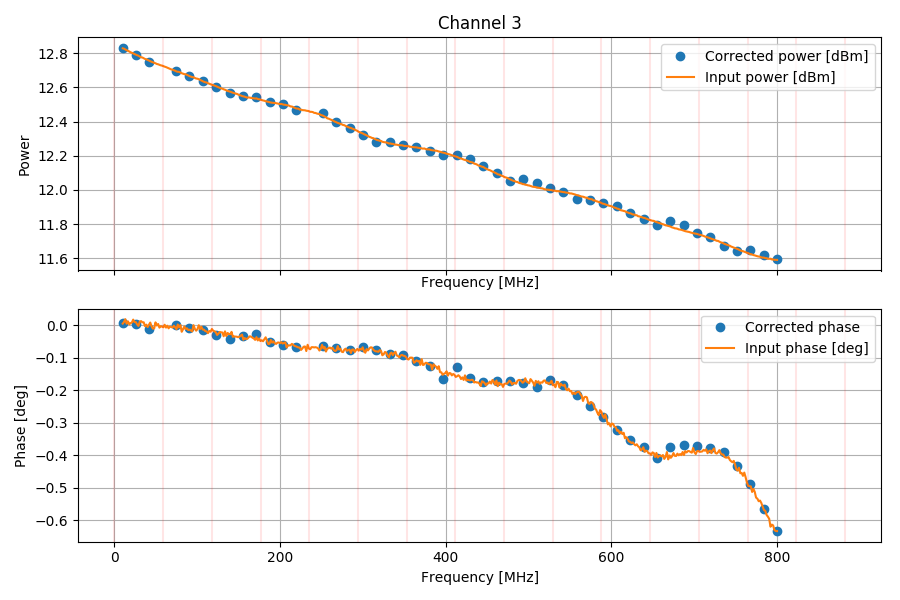

In [24]:
axs = plot_cal(3, linspace(10e6, 800e6, 50))

<IPython.core.display.Javascript object>


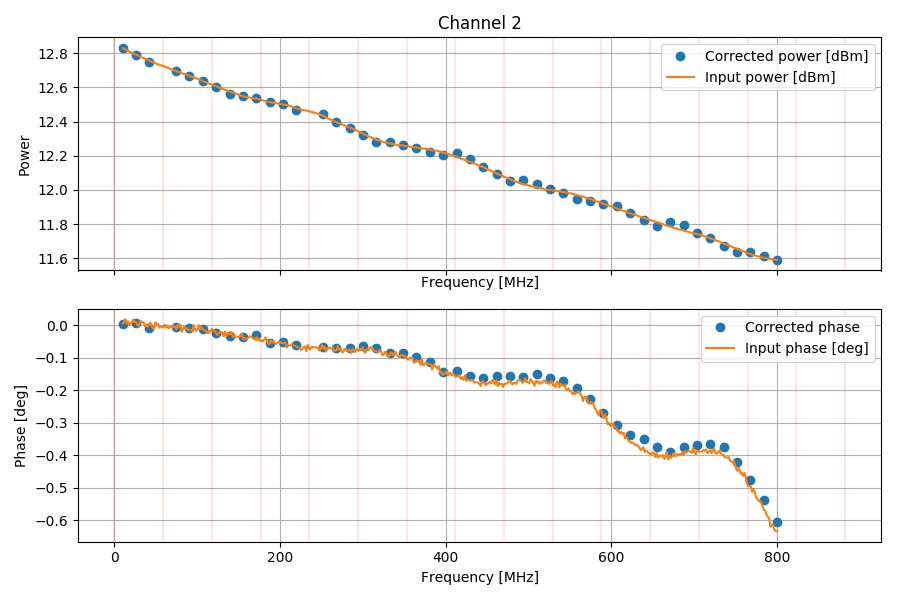

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f37d6696f28>,
      dtype=object)

In [25]:
plot_cal(2, linspace(10e6, 800e6, 50))

<IPython.core.display.Javascript object>


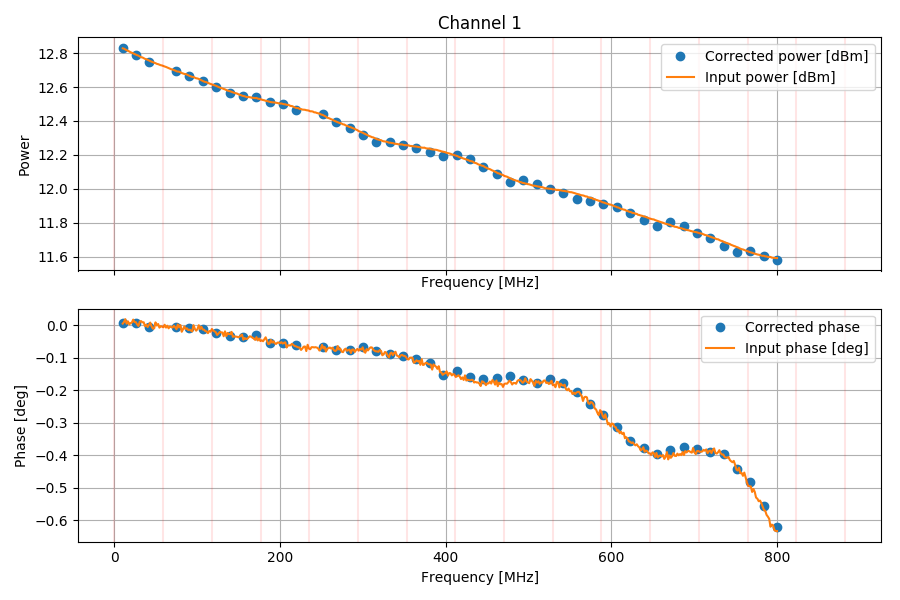

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f37d660ce80>,
      dtype=object)

In [26]:
plot_cal(1, linspace(10e6, 800e6, 50))